In [0]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

     |████████████████████████████████| 24.2MB 1.3MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 378kB 2.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.25.3)


Accessing Sentiment140 Dataset from Google Cloud Storage

In [0]:
project_id = 'ordinal-shield-258202'
from google.colab import auth
auth.authenticate_user()

In [0]:
!gcloud config set project {project_id}

Updated property [core/project].


In [0]:
!gsutil cp gs://sentiment140_dataset/training.1600000.processed.noemoticon.csv /dataset/training.csv

Copying gs://sentiment140_dataset/training.1600000.processed.noemoticon.csv...
| [1 files][227.7 MiB/227.7 MiB]                                                
Operation completed over 1 objects/227.7 MiB.                                    


In [0]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
import sklearn as sk

# Keras
import keras

# nltk
import nltk
#from nltk.corpus import stopwords
#from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [0]:
#Google Colab Functions
from google.colab import files
upload = files.upload()

Saving testdata.manual.2009.06.14.csv to testdata.manual.2009.06.14.csv
Saving training.1600000.processed.noemoticon.csv to training.1600000.processed.noemoticon.csv


In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Import dataset and create dataframe in runtime

In [0]:
dataset = pd.read_csv('/dataset/training.csv', encoding = 'latin-1', names = ["target", "ids", "date", "flag", "user", "text"])
train_set, test_set = sk.model_selection.train_test_split(dataset, test_size = 0.2, random_state = 456) #non-shuffle using random-state seed 456

In [0]:
print('Training Dataset Size: ', len(train_set))
print('Test Dataset Size: ', len(test_set))

Training Dataset Size:  1280000
Test Dataset Size:  320000


In [0]:
%%time
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]
train_set.target = train_set.target.apply(lambda x: decode_sentiment(x))
test_set.target = test_set.target.apply(lambda x: decode_sentiment(x))

CPU times: user 518 ms, sys: 4.83 ms, total: 523 ms
Wall time: 524 ms


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [0]:
# Pre-process - Sentiment Decoded DataFrames for Training and Test
train_set.head(5)

,target,ids,date,flag,user,text
1280,NEGATIVE,1468121466,Mon Apr 06 23:49:56 PDT 2009,NO_QUERY,tominlumban,"Yo jimo i cant talk on aim anymore, its glitch..."
758478,NEGATIVE,2295754798,Tue Jun 23 08:20:04 PDT 2009,NO_QUERY,jshirley,OS X apps are frustrating me by not lining up ...
1511253,POSITIVE,2175066462,Mon Jun 15 00:00:16 PDT 2009,NO_QUERY,MyAnnoyances,Going to go to bed now.. Night. I need to fig...
853234,POSITIVE,1573132983,Mon Apr 20 23:51:12 PDT 2009,NO_QUERY,VioletAngel1,is loving this oh-so-gorgeous sunny morning.. ...
1446169,POSITIVE,2062471381,Sat Jun 06 23:19:44 PDT 2009,NO_QUERY,_kaylamarie,ohhh what a day... what a day


In [0]:
test_set.head(5)

,target,ids,date,flag,user,text
499453,NEGATIVE,2186529502,Mon Jun 15 18:58:20 PDT 2009,NO_QUERY,AlaskaPoker,Mike Kaminski didn't make it to dinner in the 2k
194455,NEGATIVE,1970293065,Sat May 30 03:15:30 PDT 2009,NO_QUERY,keren4562,"@tommcfly hi, today my sister and couse &lt;or..."
1569019,POSITIVE,2188322959,Mon Jun 15 21:41:20 PDT 2009,NO_QUERY,nany_micucci,@buckhollywood THATS what im talking aboutt!! ...
596480,NEGATIVE,2219031600,Wed Jun 17 23:39:03 PDT 2009,NO_QUERY,brittneybella,realized how sad my last posting was... Does a...
793941,NEGATIVE,2326807698,Thu Jun 25 07:32:15 PDT 2009,NO_QUERY,GracieNichols,Just woke up.. My throat hurts


In [0]:
%%time
stop_words = nltk.corpus.stopwords.words("english")
stemmer = nltk.stem.SnowballStemmer("english")
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

train_set.text = train_set.text.apply(lambda x: preprocess(x))
test_set.text = test_set.text.apply(lambda x: preprocess(x))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


CPU times: user 43.5 s, sys: 150 ms, total: 43.6 s
Wall time: 43.7 s


In [0]:
# Post-processed - Sentiment Decoded and Text Processed DataFrames
train_set.head(5)

,target,ids,date,flag,user,text
1280,NEGATIVE,1468121466,Mon Apr 06 23:49:56 PDT 2009,NO_QUERY,tominlumban,yo jimo cant talk aim anymore glitching ill cy...
758478,NEGATIVE,2295754798,Tue Jun 23 08:20:04 PDT 2009,NO_QUERY,jshirley,os x apps frustrating lining tidy arrangement ...
1511253,POSITIVE,2175066462,Mon Jun 15 00:00:16 PDT 2009,NO_QUERY,MyAnnoyances,going go bed night need figure way get subscri...
853234,POSITIVE,1573132983,Mon Apr 20 23:51:12 PDT 2009,NO_QUERY,VioletAngel1,loving oh gorgeous sunny morning great day twi...
1446169,POSITIVE,2062471381,Sat Jun 06 23:19:44 PDT 2009,NO_QUERY,_kaylamarie,ohhh day day


In [0]:
test_set.head(5)

,target,ids,date,flag,user,text
499453,NEGATIVE,2186529502,Mon Jun 15 18:58:20 PDT 2009,NO_QUERY,AlaskaPoker,mike kaminski make dinner 2k
194455,NEGATIVE,1970293065,Sat May 30 03:15:30 PDT 2009,NO_QUERY,keren4562,hi today sister couse lt amp roni gt birthday ...
1569019,POSITIVE,2188322959,Mon Jun 15 21:41:20 PDT 2009,NO_QUERY,nany_micucci,thats im talking aboutt hahhaa
596480,NEGATIVE,2219031600,Wed Jun 17 23:39:03 PDT 2009,NO_QUERY,brittneybella,realized sad last posting anyone want friend lol
793941,NEGATIVE,2326807698,Thu Jun 25 07:32:15 PDT 2009,NO_QUERY,GracieNichols,woke throat hurts


Word2Vec - Generate word embeddings for embedding layer of LSTM

In [0]:
%%time
documents = [_text.split() for _text in train_set.text] 

CPU times: user 2.72 s, sys: 313 ms, total: 3.04 s
Wall time: 3.04 s


In [0]:
print(len(documents))

1280000


In [0]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=5, 
                                            min_count=10, 
                                            workers=8)

In [0]:
w2v_model.build_vocab(documents)

2019-12-08 17:07:56,980 : INFO : collecting all words and their counts
2019-12-08 17:07:56,983 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-12-08 17:07:57,015 : INFO : PROGRESS: at sentence #10000, processed 72327 words, keeping 14106 word types
2019-12-08 17:07:57,038 : INFO : PROGRESS: at sentence #20000, processed 144160 words, keeping 21397 word types
2019-12-08 17:07:57,060 : INFO : PROGRESS: at sentence #30000, processed 216408 words, keeping 27464 word types
2019-12-08 17:07:57,083 : INFO : PROGRESS: at sentence #40000, processed 288821 words, keeping 32900 word types
2019-12-08 17:07:57,106 : INFO : PROGRESS: at sentence #50000, processed 360337 words, keeping 37687 word types
2019-12-08 17:07:57,130 : INFO : PROGRESS: at sentence #60000, processed 432591 words, keeping 42176 word types
2019-12-08 17:07:57,154 : INFO : PROGRESS: at sentence #70000, processed 504923 words, keeping 46272 word types
2019-12-08 17:07:57,177 : INFO : PROGRESS: at s

In [0]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30368


In [0]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=16)

2019-12-08 17:08:16,308 : INFO : training model with 8 workers on 30368 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2019-12-08 17:08:17,338 : INFO : EPOCH 1 - PROGRESS: at 4.66% examples, 379608 words/s, in_qsize 15, out_qsize 0
2019-12-08 17:08:18,365 : INFO : EPOCH 1 - PROGRESS: at 9.52% examples, 384917 words/s, in_qsize 15, out_qsize 0
2019-12-08 17:08:19,441 : INFO : EPOCH 1 - PROGRESS: at 14.84% examples, 392073 words/s, in_qsize 15, out_qsize 0
2019-12-08 17:08:20,457 : INFO : EPOCH 1 - PROGRESS: at 19.51% examples, 388351 words/s, in_qsize 15, out_qsize 1
2019-12-08 17:08:21,508 : INFO : EPOCH 1 - PROGRESS: at 24.70% examples, 392093 words/s, in_qsize 14, out_qsize 1
2019-12-08 17:08:22,565 : INFO : EPOCH 1 - PROGRESS: at 29.80% examples, 392754 words/s, in_qsize 14, out_qsize 1
2019-12-08 17:08:23,577 : INFO : EPOCH 1 - PROGRESS: at 34.67% examples, 393231 words/s, in_qsize 16, out_qsize 1
2019-12-08 17:08:24,578 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 10min 38s, sys: 2.49 s, total: 10min 40s
Wall time: 5min 28s


(131617920, 147714720)

In [0]:
# Verify word2vec
w2v_model.most_similar("hello")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-12-08 17:14:15,064 : INFO : precomputing L2-norms of word weight vectors


[('hi', 0.6493086814880371),
 ('hola', 0.5555077195167542),
 ('howdy', 0.4950813055038452),
 ('hallo', 0.48477137088775635),
 ('welcome', 0.4825419485569),
 ('hiya', 0.4766293466091156),
 ('ello', 0.45281898975372314),
 ('goodmorning', 0.4403824210166931),
 ('hellooooo', 0.42675065994262695),
 ('hellooo', 0.4163074493408203)]

In [0]:
w2v_model.most_similar("world")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('earth', 0.4733542203903198),
 ('worlds', 0.4601503312587738),
 ('twitterverse', 0.3618454933166504),
 ('planet', 0.35915687680244446),
 ('intentions', 0.3490403890609741),
 ('universe', 0.34094446897506714),
 ('europe', 0.33531251549720764),
 ('life', 0.32862305641174316),
 ('truely', 0.3129270672798157),
 ('heartedly', 0.29963281750679016)]

In [0]:
%%time
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_set.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 291132
CPU times: user 20.3 s, sys: 94 ms, total: 20.4 s
Wall time: 20.4 s


In [0]:
tokenizer.texts_to_sequences(train_set.text)[0]

[853, 105149, 84, 234, 1909, 292, 35075, 293, 4664, 181, 38, 15, 21]

In [0]:
tokenizer.texts_to_sequences(train_set.text)[0]

[853, 105149, 84, 234, 1909, 292, 35075, 293, 4664, 181, 38, 15, 21]

In [0]:
%%time
x_train = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(train_set.text), maxlen=300) #Standardize Text input for model training
x_test = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(test_set.text), maxlen=300) #Standardize Text input for test evaluation
print('x_train', x_train.shape)
print('x_test', x_test.shape)

x_train (1280000, 300)
x_test (320000, 300)
CPU times: user 28.2 s, sys: 539 ms, total: 28.8 s
Wall time: 28.8 s


In [0]:
labels = train_set.target.unique().tolist()
labels.append('NEUTRAL')
labels

#Encode Labels
encoder = sk.preprocessing.LabelEncoder()
encoder.fit(train_set.target.tolist())

y_train = encoder.transform(train_set.target.tolist())
y_test = encoder.transform(test_set.target.tolist())
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

y_train (1280000, 1)
y_test (320000, 1)


In [0]:
# Create the embedding layer
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(291132, 300)


In [0]:
embedding_layer = keras.layers.Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)  #Frozen Embedding Layer

In [0]:
# Create the LSTM RNN model
model = keras.models.Sequential()
model.add(embedding_layer)
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.LSTM(200, dropout = 0.2, recurrent_dropout=0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [0]:
from google.colab import files
keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
files.download('model_plot.png')

In [0]:
model.summary()
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 300)          87339600  
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 87,740,601
Trainable params: 401,001
Non-trainable params: 87,339,600
_________________________________________________________________


In [0]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [0]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=1024,
                    epochs=16,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/16
1152000/1152000 [==============================] - 473s 411us/step - loss: 0.5000 - accuracy: 0.7531 - val_loss: 0.4615 - val_accuracy: 0.7797
Epoch 2/16
1152000/1152000 [==============================] - 471s 409us/step - loss: 0.4745 - accuracy: 0.7704 - val_loss: 0.4538 - val_accuracy: 0.7849
Epoch 3/16
1152000/1152000 [==============================] - 482s 419us/step - loss: 0.4791 - accuracy: 0.7676 - val_loss: 0.4523 - val_accuracy: 0.7852
Epoch 4/16
1152000/1152000 [==============================] - 489s 424us/step - loss: 0.4682 - accuracy: 0.7747 - val_loss: 0.4503 - val_accuracy: 0.7862
Epoch 5/16
1152000/1152000 [==============================] - 495s 429us/step - loss: 0.4631 - accuracy: 0.7774 - val_loss: 0.4460 - val_accuracy: 0.7888
Epoch 6/16
1152000/1152000 [==============================] - 472s 409us/step - loss: 0.4612 - accuracy: 0.7789 - val_loss: 0.4455 - val_accuracy: 0.7901
Epoch 7/16
1152000/1152

In [0]:
%%time
score = model.evaluate(x_test, y_test, batch_size=512)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 122s 382us/step

ACCURACY: 0.7948437333106995
LOSS: 0.43791103701591494
CPU times: user 2min 48s, sys: 19.7 s, total: 3min 7s
Wall time: 2min 2s


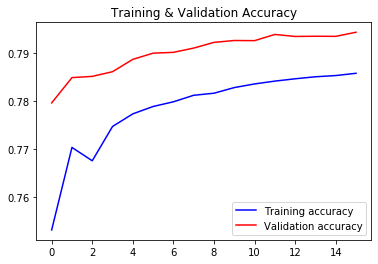

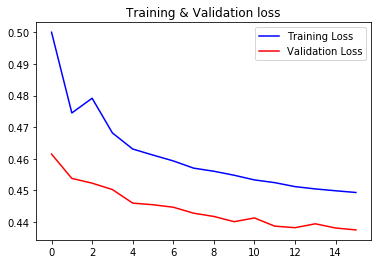

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training & Validation loss')
plt.legend()
 
plt.show()

In [0]:
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
def decode_sentiment(score, include_neutral=False):
    if include_neutral:        
        label = NEUTRAL
        if score <= 0.4:
            label = NEGATIVE
        elif score >= 0.7:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [0]:
def predict(text, include_neutral=False):
    start_at = time.time()
    # Tokenize text
    x_test = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"Sentiment Detected": label, "Score": float(score)}

In [0]:
predict("I hate how much I love the music")

{'elapsed_time': 0.210371732711792,
 'label': 'NEGATIVE',
 'score': 0.38716843724250793}

In [0]:
predict('This ipad is not terrible')

{'elapsed_time': 0.19127631187438965,
 'label': 'NEGATIVE',
 'score': 0.020990310236811638}

In [0]:
predict('I dont know how to feel about this movie. Its good at some points and bad at others. I think I dont like it')

{'elapsed_time': 0.18977093696594238,
 'label': 'NEGATIVE',
 'score': 0.12482161819934845}